In [249]:
import numpy as np
import matplotlib.pyplot as plt
import random

import pystan

In [288]:
num_players = 285
num_games = 1687
prior_fake = np.arange(num_players, 0, -1)
prior_score_fake = (prior_fake - np.mean(prior_fake)) / (2 * np.std(prior_fake, ddof=1))

ranks = np.array([random.sample(range(num_players), k=2) for i in range(num_games)]) + 1
player_1_white = np.random.binomial(1, 0.5, num_games)

### Set-up model

In [267]:
model = pystan.StanModel("../stan_models/fake_data_sim.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f61767c37a1aa0e91294becd1a999b1 NOW.


In [425]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score_fake,
    "player_1_rank": ranks[:, 0],
    "player_2_rank": ranks[:, 1],
    "player_1_white": player_1_white,
    "b_mu": 0.25,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.75, 1.25]),
    "c_scale": 0.5,
    "w_mu": 0.5,
    "w_scale": 0.25,
}

In [426]:
fit = model.sampling(data=stan_data)

params = fit.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Plotting

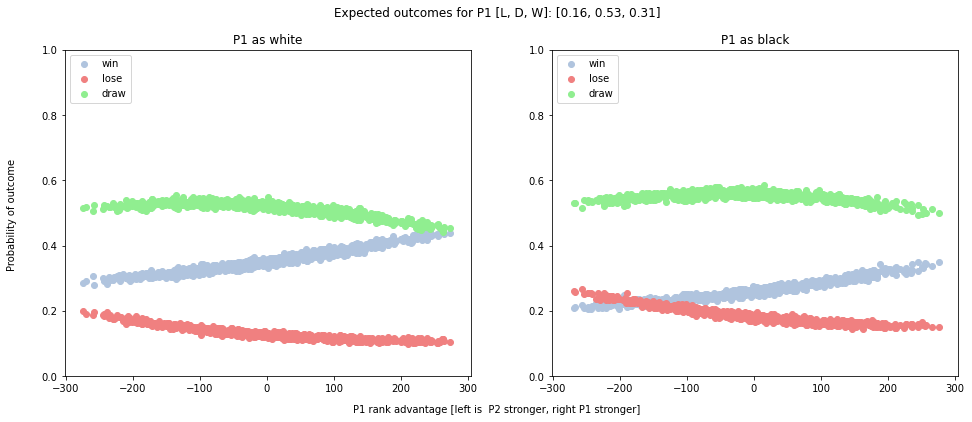

In [427]:
rank_diffs = ranks[:, 1] - ranks[:, 0]

out = np.array([np.sum(params["ypred"] == l, 0) for l in [1, 2, 3]]).T
out_prob = out/np.mean(out.sum(1))
expected_outcomes = [np.round(i, 2) for i in out_prob.mean(0)]

p1_mask = player_1_white == 1

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
ax = ax.ravel()

ax[0].scatter(rank_diffs[p1_mask], out_prob[:, 2][p1_mask], label="win", color="lightsteelblue");
ax[1].scatter(rank_diffs[~p1_mask], out_prob[:, 2][~p1_mask], label="win", color="lightsteelblue");

ax[0].scatter(rank_diffs[p1_mask], out_prob[:, 0][p1_mask], label="lose", color="lightcoral");
ax[1].scatter(rank_diffs[~p1_mask], out_prob[:, 0][~p1_mask], label="lose", color="lightcoral");

ax[0].scatter(rank_diffs[p1_mask], out_prob[:, 1][p1_mask], label="draw", color="lightgreen");
ax[1].scatter(rank_diffs[~p1_mask], out_prob[:, 1][~p1_mask], label="draw", color="lightgreen");

ax[0].set_title("P1 as white");
ax[1].set_title("P1 as black");

ax[0].set_ylim(0, 1);
ax[1].set_ylim(0, 1);

ax[0].legend(loc="upper left");
ax[1].legend(loc="upper left");
fig.text(0.5, 0.04, "P1 rank advantage [left is  P2 stronger, right P1 stronger]", ha="center")
fig.text(0.075, 0.5, "Probability of outcome", va="center", rotation="vertical")

plt.suptitle(f"Expected outcomes for P1 [L, D, W]: {expected_outcomes}");